## Homework 3: Due 2018-10-24

Write a solver for the regularized $p$-Laplacian,
$$ -\nabla\cdot\big( \kappa(\nabla u) \nabla u \big) = 0 $$
where
$$ \kappa(\nabla u) = \big(\frac 1 2 \epsilon^2 + \frac 1 2 \nabla u \cdot \nabla u \big)^{\frac{p-2}{2}}, $$
$ \epsilon > 0$, and $1 < p < \infty$.  The case $p=2$ is the conventional Laplacian. This problem gets more strongly nonlinear when $p$ is far from 2 and when $\epsilon$ approaches zero. The $p \to 1$ limit is related to plasticity and has applications in non-Newtonion flows and structural mechanics.

1. Implement a "Picard" solver, which is like a Newton solver except that the Jacobian is replaced by the linear system
$$ J_{\text{Picard}}(u) \delta u \sim -\nabla\cdot\big( \kappa(\nabla u) \nabla \delta u \big) . $$
This is much easier to implement than the full Newton linearization.  How fast does this method converge for values of $p < 2$ and $p > 2$?




In [54]:
import numpy
import matplotlib.pyplot as pyplot
import scipy.sparse as sp
import scipy.sparse.linalg
pyplot.style.use('ggplot')

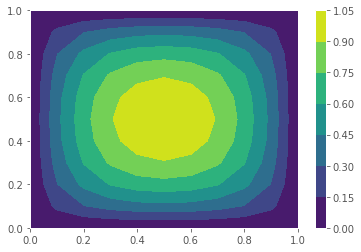

In [55]:
def hgrid(h):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = numpy.linspace(0, 1, m)
    y, x = numpy.meshgrid(c, c)
    return x, y

def picard2d_div(h, x, y, u, forcing, g0,p,epsilon, dirichlet=((),()), J_solve=True):
    m = x.shape[0]
    u0 = g0(x, y).flatten()
    F = -forcing(x, y).flatten()
    ai = []
    aj = []
    av = []
    def idx(i, j):
        i = (m-1) - abs(m-1 - abs(i))
        j = (m-1) - abs(m-1 - abs(j))
        return i*m + j
    mask = numpy.ones_like(x, dtype=bool)
    mask[dirichlet[0],:] = False
    mask[:,dirichlet[1]] = False
    mask = mask.flatten()
    u = u.flatten()
    F[mask == False] = u[mask == False] - u0[mask == False]
    u[mask == False] = u0[mask == False]
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = numpy.array([idx(*pair) for pair in [(i-1,j-1), (i-1, j), (i-1,j+1), 
                                                            (i, j-1), (i, j), (i, j+1),
                                                            (i+1,j-1), (i+1, j), (i+1, j+1)]])
            #calculate the points necessary for gradients in both directions for kappa
            spoints = numpy.array(([[0, 0, 0, -1, 1, 0, 0, 0, 0],
                                    [-1/4, -1/4, 0, 0, 0, 0, 1/4, 1/4, 0],
                                    [0, 0, 0, -1/4, 0, 1/4, -1/4, 0, 1/4],
                                    [0, 0, 0, 0, -1, 0, 0, 1, 0],
                                    [0, 0, 0, 0, -1, 1, 0, 0, 0],
                                    [0, -1/4, -1/4, 0, 0, 0, 0, 1/4, 1/4], 
                                    [-1/4, 0, 1/4, -1/4, 0, 1/4, 0, 0, 0],
                                    [0, -1, 0, 0, 1, 0, 0, 0, 0]]))/(h)
            grad = numpy.array([[0, -1, 0, 0, 1, 0, 0, 0, 0],
                                [0, 0, 0, -1, 1, 0, 0, 0, 0],
                                [0, 0, 0, 0, -1, 1, 0, 0, 0],
                                [0, 0, 0, 0, -1, 0, 0, 1, 0]]) / h
            # Stencil to compute divergence at cell centers from fluxes at four staggered points
            div = numpy.array([-1, -1, 1, 1]) / h
            ustencil = u[stencili]
            gradient = spoints @ ustencil
            kappa = [((epsilon**2)/2 + gradient[2*i]**2 + gradient[2*i + 1]**2)**((p-2)/2) for i in numpy.arange(0,4)]
            if mask[row] == 0: # Dirichlet boundary
                ai.append(row)
                aj.append(row)
                av.append(1)
            else:
                F[row] -= div @ (kappa * (grad @ ustencil))
                if(J_solve):
                    Jstencil = -div @ ([kappa[i] * grad[i] for i in range(0, len(kappa))])
                    smask = mask[stencili]
                    ai += [row]*sum(smask)
                    aj += stencili[smask].tolist()
                    av += Jstencil[smask].tolist()
    if(J_solve):
        J = sp.csc_matrix((av, (ai, aj)), shape=(m*m,m*m))
        return F, J
    else:
        return F

h = .1
x, y = hgrid(h)
u = 0*x
F, J = picard2d_div(h, x, y, u, lambda x,y: 0*x+1,
                       lambda x,y: 0*x, 3, .1, dirichlet=((0,-1),(0,-1)))
deltau = sp.linalg.spsolve(J, -F).reshape(x.shape)
pyplot.contourf(x, y, deltau)
pyplot.colorbar();

 0: anorm 1.000000e+00
 1: anorm 1.029516e+00
 2: anorm 3.557134e-01
 3: anorm 1.365775e-01
 4: anorm 4.433955e-02
 5: anorm 1.388288e-02
 6: anorm 4.132562e-03
 7: anorm 1.187124e-03
 8: anorm 3.313585e-04
 9: anorm 9.038185e-05
10: anorm 2.418823e-05
11: anorm 6.371621e-06
12: anorm 1.656129e-06
13: anorm 4.256086e-07
14: anorm 1.083179e-07
15: anorm 2.733677e-08
16: anorm 6.849038e-09
16


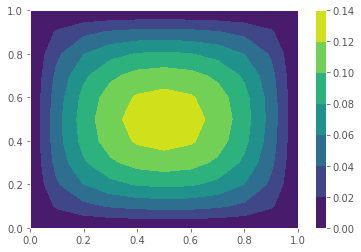

In [3]:
def solve_nonlinear(h, g0, dirichlet, p, eps, atol=1e-8, verbose=False):
    x, y = hgrid(h)
    u = 0*x
    for i in range(500):
        F, J = picard2d_div(h, x, y, u, lambda x,y: 0*x+1,
                               lambda x,y: 0*x, p, eps, dirichlet=((0,-1),(0,-1)))
        anorm = numpy.linalg.norm(F, numpy.inf)
        if verbose:
            print('{:2d}: anorm {:8e}'.format(i,anorm))
        if anorm < atol:
            break
        #solve for delta u
        deltau = sp.linalg.spsolve(J, -F)
        #update u based on delta u
        u += deltau.reshape(x.shape)
    return x, y, u, i

x, y, u, i = solve_nonlinear(.1, lambda x,y: 0*x, ((0,-1),(0,-1)), 4, 1, verbose=True)
print(i)
pyplot.contourf(x, y, u)
pyplot.colorbar();

# Convergence study of p > 2 and p < 2

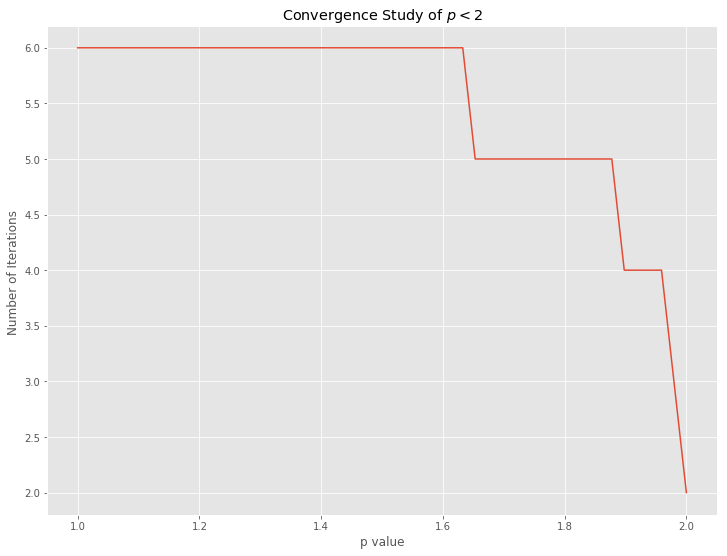

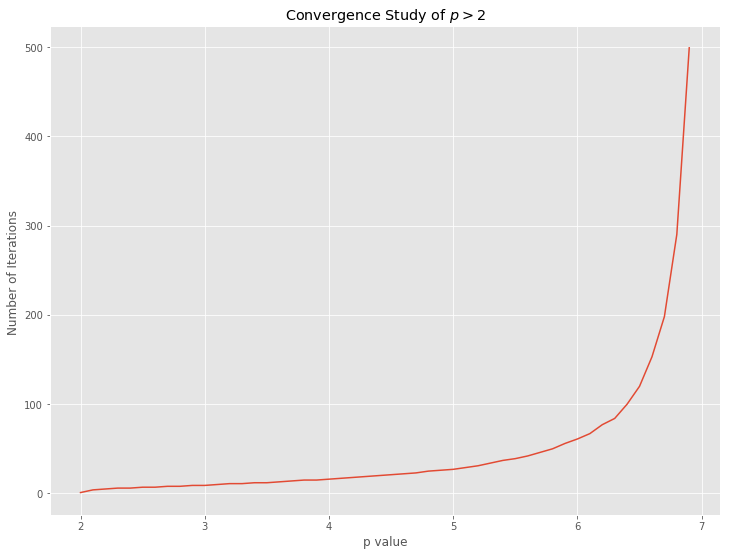

In [4]:
p_vals_under2 = numpy.linspace(1.00001, 2-.00001)
p_vals_above2 = numpy.linspace(2, 6.9)
p_vals = numpy.concatenate((p_vals_under2, p_vals_above2))
iterations = []
for p in p_vals_under2:
    x,y,u,i = solve_nonlinear(.1, lambda x,y: 0*x, ((0,-1),(0,-1)), p, 1, verbose=False)
    iterations.append(i)
pyplot.figure(figsize=(12,9))
pyplot.title(r'Convergence Study of $p<2$')
pyplot.xlabel('p value')
pyplot.ylabel('Number of Iterations ')
pyplot.plot(p_vals_under2, iterations)
pyplot.show();
iterations = []
for p in p_vals_above2:
    x,y,u,i = solve_nonlinear(.1, lambda x,y: 0*x, ((0,-1),(0,-1)), p, 1, verbose=False)
    iterations.append(i)
pyplot.figure(figsize=(12,9))
pyplot.title(r'Convergence Study of $p>2$')
pyplot.xlabel('p value')
pyplot.ylabel('Number of Iterations ')
pyplot.plot(p_vals_above2, iterations)
pyplot.show();

# Convergence study of $\epsilon$ 

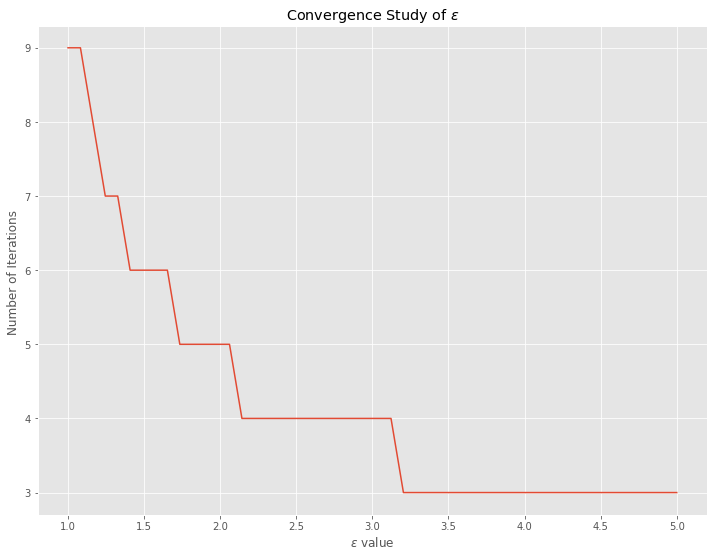

In [5]:
eps = numpy.linspace(1, 5)
iterations = []
for e in eps:
    x,y,u,i = solve_nonlinear(.1, lambda x,y: 0*x, ((0,-1),(0,-1)), 3, e, verbose=False)
    iterations.append(i)
pyplot.figure(figsize=(12,9))
pyplot.title(r'Convergence Study of $\epsilon$')
pyplot.xlabel(r'$\epsilon$ value')
pyplot.ylabel('Number of Iterations ')
pyplot.plot(eps, iterations)
pyplot.show();

Use the linearization above as a preconditioner to a Newton-Krylov method.  That is, use [`scipy.sparse.linalg.LinearOperator`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.LinearOperator.html) to apply the Jacobian to a vector
$$ \tilde J(u) v = \frac{F(u + h v) - F(u)}{h} . $$
Then for each linear solve, use [`scipy.sparse.linalg.gmres`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.gmres.html) and pass as a preconditioner, a direct solve with the Picard linearization above. (You might find [`scipy.sparse.linalg.factorized`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.factorized.html#scipy.sparse.linalg.factorized) to be useful. Compare algebraic convergence to that of the Picard method. (choose h to be around $10^{-8}$)

In [130]:
import scipy.sparse.linalg as splinalg
from scipy.sparse.linalg import factorized
from numpy.linalg import norm as n

def fsolve_newtonkrylov(F, J, u0, epsilon=1e-6, rtol=1e-10, maxit=50, verbose=False):
    u = u0.copy()
    #initial norm on residual
    norm0 = numpy.linalg.norm(F)
    for i in range(maxit):
        def Ju_fd(v):
            print(n(v))
            v = v.reshape(u.shape)
            Fuv = picard2d_div(h, x, y, u + epsilon*v, 
                              lambda x,y: 0*x + 1, lambda x,y: 0*x, 3, 1, 
                               dirichlet=((),()), J_solve=False)
            print(n(Fuv), n(Fuv - F), n(u), n(v))
            return (Fuv - F) / epsilon
        #this creates an operator ~ to J(u) based on the matvec function
        Ju = splinalg.LinearOperator((len(F),len(F)), matvec=Ju_fd)
        #solving for du s.t. J(u)*du = -F(u) (the negative is moved below for a slight increase in efficiency)
        solve = factorized(J)
        J_inv = splinalg.LinearOperator((len(F), len(F)), solve)
        du, info = splinalg.gmres(Ju, F, M=J_inv)
        print(n(Ju @ F))
        if info != 0:
            raise RuntimeError('GMRES failed to converge: {:d}'.format(info))
        du = du.reshape(u.shape)
        u -= du
        F = picard2d_div(h, x, y, u, lambda x,y: 0*x +1, lambda x,y: 0*x, 3, 1,
                        dirichlet=((), ()), J_solve=False)
        norm = numpy.linalg.norm(F)
        if verbose:
            print('Newton {:d} anorm {:6.2e} rnorm {:6.2e}'.format(i, norm, norm/norm0))
        if norm < rtol * norm0:
            break
    return u, i

h = .1
x, y = hgrid(h)
u = 0*x
F, J = picard2d_div(h, x, y, u, lambda x,y: 0*x +1, lambda x,y: 0*x, 3, 1, dirichlet=((), ()))
fsolve_newtonkrylov(F,J,u, rtol=1e-6, verbose=True)

0.0
11.0 0.0 0.0 0.0
0.0
11.0 0.0 0.0 0.0
1.0
11.0 0.0 0.0 1.0
11.0
11.0 0.0 0.0 11.0
0.0
Newton 0 anorm    nan rnorm    nan
0.0
nan nan inf 0.0
0.0
nan nan inf 0.0
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf

nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan
nan nan inf nan
nan


KeyboardInterrupt: 

* Can you directly implement a Newton linearization?  Either do it or explain what is involved.  How will its nonlinear convergence compare to that of the Newton-Krylov method?

For a direct implementation of a Newton linearization, there would be more terms involved. Instead of having $$ J_{\text{Picard}}(u) \delta u \sim -\nabla\cdot\big( \kappa(\nabla u) \nabla \delta u \big)  $$ we need to use $$ J = -\nabla\cdot (\kappa(\nabla u) \nabla \delta u + \kappa'(\nabla u)\nabla u) $$

To implement this we would need to calculate the gradient for the staggered points in both directions (like before) and then calculate the derivative of $\kappa$ with respect to u. For the regularized p laplacian, this makes $$\kappa'(\nabla u) = \frac{p-2}{2}\big (\frac{1}{2}\varepsilon^2 + \frac{1}{2}\nabla u\cdot\nabla\ u\big )^{\frac{p-4}{2}}\nabla u\cdot\nabla$$ which makes the second term $$ \frac{p-2}{2}\big (\frac{1}{2}\varepsilon^2 + \frac{1}{2}\nabla u\cdot\nabla\ u\big )^{\frac{p-4}{2}}\nabla u\cdot\nabla^2 u $$

Now we need to calculate second derivatives as well as first for u which will require either another stencil or a differencing method using the stencil from the picard solver. 

Compared to the Newton-Krylov method, this method should converge at a higher rate. The Newton-Krylov method is comparable to finite differencing techniques and is first order accurate based on the choice of $\varepsilon$ while the Newton method is a higher order of accuracy (at least second order accurate like the divergence or nondivergence methods from FD2D).